# Looking inside Delphi with SHAP values

Welcome to the Delphi SHAP notebook!

Delphi is a generative autoregressive model that not only predicts the future disease rates, but also sample entire disease trajectories one step at a time.

In this notebook, we will use SHAP (SHapley Additive exPlanations) framework to analyse which interaction between diseases that Delphi learned from data and how these interaction influence its predicitons. 

Let's start by looking at what SHAP values mean:

## SHAP Values and Delphi

SHAP (SHapley Additive exPlanations) values help us understand how a machine learning model makes its predictions by showing the contribution of each input feature.


### Example: Patient Trajectory

Consider a simplified patient trajectory:
`Male, Migraine, Common cold, Brain cancer`

For this trajectory, Delphi would predict a very high mortality risk (aka high rate for the Death token being next). Say, 95% chance of death within a year. Why? Technically, we don't know, since neural networks are black boxes. 

Let's try masking several tokens and predicting the next token again.

`Male, [Masked: Migraine], Common cold, Brain cancer` -> 95% chance of death within a year, no change

`Male, Migraine, Common cold, [Masked: Brain cancer]` -> 5% chance of death within a year, risk drops significantly

Without speaking about causality, we can assume that there is *some* connection between brain cancer and death risk. SHAP framework allows using such masking to systematically assess the contribution of each token to the prediction. We can perform this analysis for all trajectories in the dataset and evaluate how, on average, a given disease influences the risk of any other disease.

In case of Delphi, masking means replacing a disease token with "no event" token for all input tokens, except for the sex token that is inverted.

In [2]:
import os
import pickle
import torch
from model import DelphiConfig, Delphi
from tqdm import tqdm
import pandas as pd
import numpy as np
import textwrap
import warnings

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})
plt.rcParams['figure.dpi']= 72
plt.rcParams['pdf.fonttype'] = 42

delphi_labels = pd.read_csv('delphi_labels_chapters_colours_icd.csv')

## Load model

In [3]:
out_dir = 'Delphi-2M'
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype ='float32' #'bfloat16' # 'float32' or 'bfloat16' or 'float16'
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True 

device_type = 'cuda' if 'cuda' in device else 'cpu'
dtype = {'float32': torch.float32, 'float64': torch.float64, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

In [4]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
conf = DelphiConfig(**checkpoint['model_args'])
model = Delphi(conf)
state_dict = checkpoint['model']
model.load_state_dict(state_dict)

model.eval()
model = model.to(device)

number of parameters: 2.24M


## Load data

In [5]:
from utils import get_batch, get_p2i

train = np.fromfile('data/ukb_simulated_data/train.bin', dtype=np.uint32).reshape(-1,3)
val = np.fromfile('data/ukb_simulated_data/val.bin', dtype=np.uint32).reshape(-1,3)

train_p2i = get_p2i(train)
val_p2i = get_p2i(val)

In [6]:
# define a random example health trajectory

person = [('Male', 0),
 ('B01 Varicella [chickenpox]',2),
 ('L20 Atopic dermatitis',3),
 ('Healthy', 5),
 ('Healthy', 10),
 ('Healthy', 15),
 ('Healthy', 20),
 ('G43 Migraine', 20),
 ('E73 Lactose intolerance', 21),
 ('B27 Infectious mononucleosis', 22),
 ('Healthy', 25),
 ('J11 Influenza, virus not identified', 28),
 ('Healthy', 30),
 ('Healthy', 35),
 ('C25 Malignant neoplasm of pancreas', 38),
 ('Healthy', 40),
 ('Smoking low', 41),
 ('BMI mid', 41),
 ('Alcohol high', 41),
 ('Healthy', 42),
]
person = [(a, b * 365.25) for a,b in person] 

### Individual SHAP values

In [7]:
# define helper functions

id_to_token = delphi_labels['name'].to_dict()
token_to_id = {v:k for k, v in id_to_token.items()}

def tokens_to_ids(tokens):
    return [token_to_id[t] for t in tokens]

def ids_to_tokens(ids):
    return [id_to_token[int(id_)] for id_ in ids]

def split_person(p):
    tokens = [i[0] for i in p]
    ages = [i[1] for i in p]
    return tokens, ages

def get_person(idx):
    x, y, _, time = get_batch([idx], val, val_p2i,  
              select='left', block_size=48, 
              device=device, padding='random')
    x, y = x[y > -1], y[y > -1]
    person = []
    for token_id, date in zip(x, y):
        person.append((id_to_token[token_id.item()], date.item()))
    return person, y, time[0][-1]

In [8]:
from utils import shap_custom_tokenizer, shap_model_creator
import shap

# person_to_process = get_person(137)[0]
person_to_process = person
diseases_of_interest = [1269, 46, 95, 1168, 374, 173, 214, 305, 505, 584]

person_tokens, person_ages = split_person(person_to_process)
person_tokens_ids = tokens_to_ids(person_tokens)

masker = shap.maskers.Text(shap_custom_tokenizer, output_type='str', mask_token='10000', collapse_mask_token=False)
model_shap = shap_model_creator(model, diseases_of_interest, person_tokens_ids, person_ages, device)
explainer = shap.Explainer(model_shap, masker, output_names=delphi_labels['name'].values[diseases_of_interest])

shap_values = explainer([' '.join(list(map(lambda x: str(token_to_id[x]), person_tokens)))])
shap_values.data = np.array([list(map(lambda x: f"{delphi_labels['name'].values[token_to_id[x[0]]]}({x[1]/365:.1f} years) ", person_to_process))])

/omics/groups/OE0606/internal/art1m/micromamba/envs/delphi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PartitionExplainer explainer: 2it [00:12, 12.28s/it]                                                                                                                                                                                           


In [9]:
out = shap.plots.text(shap_values, display=True) # sometimes this interactive plot can't be rendered well (eg in VS Code, feel free to skip it)

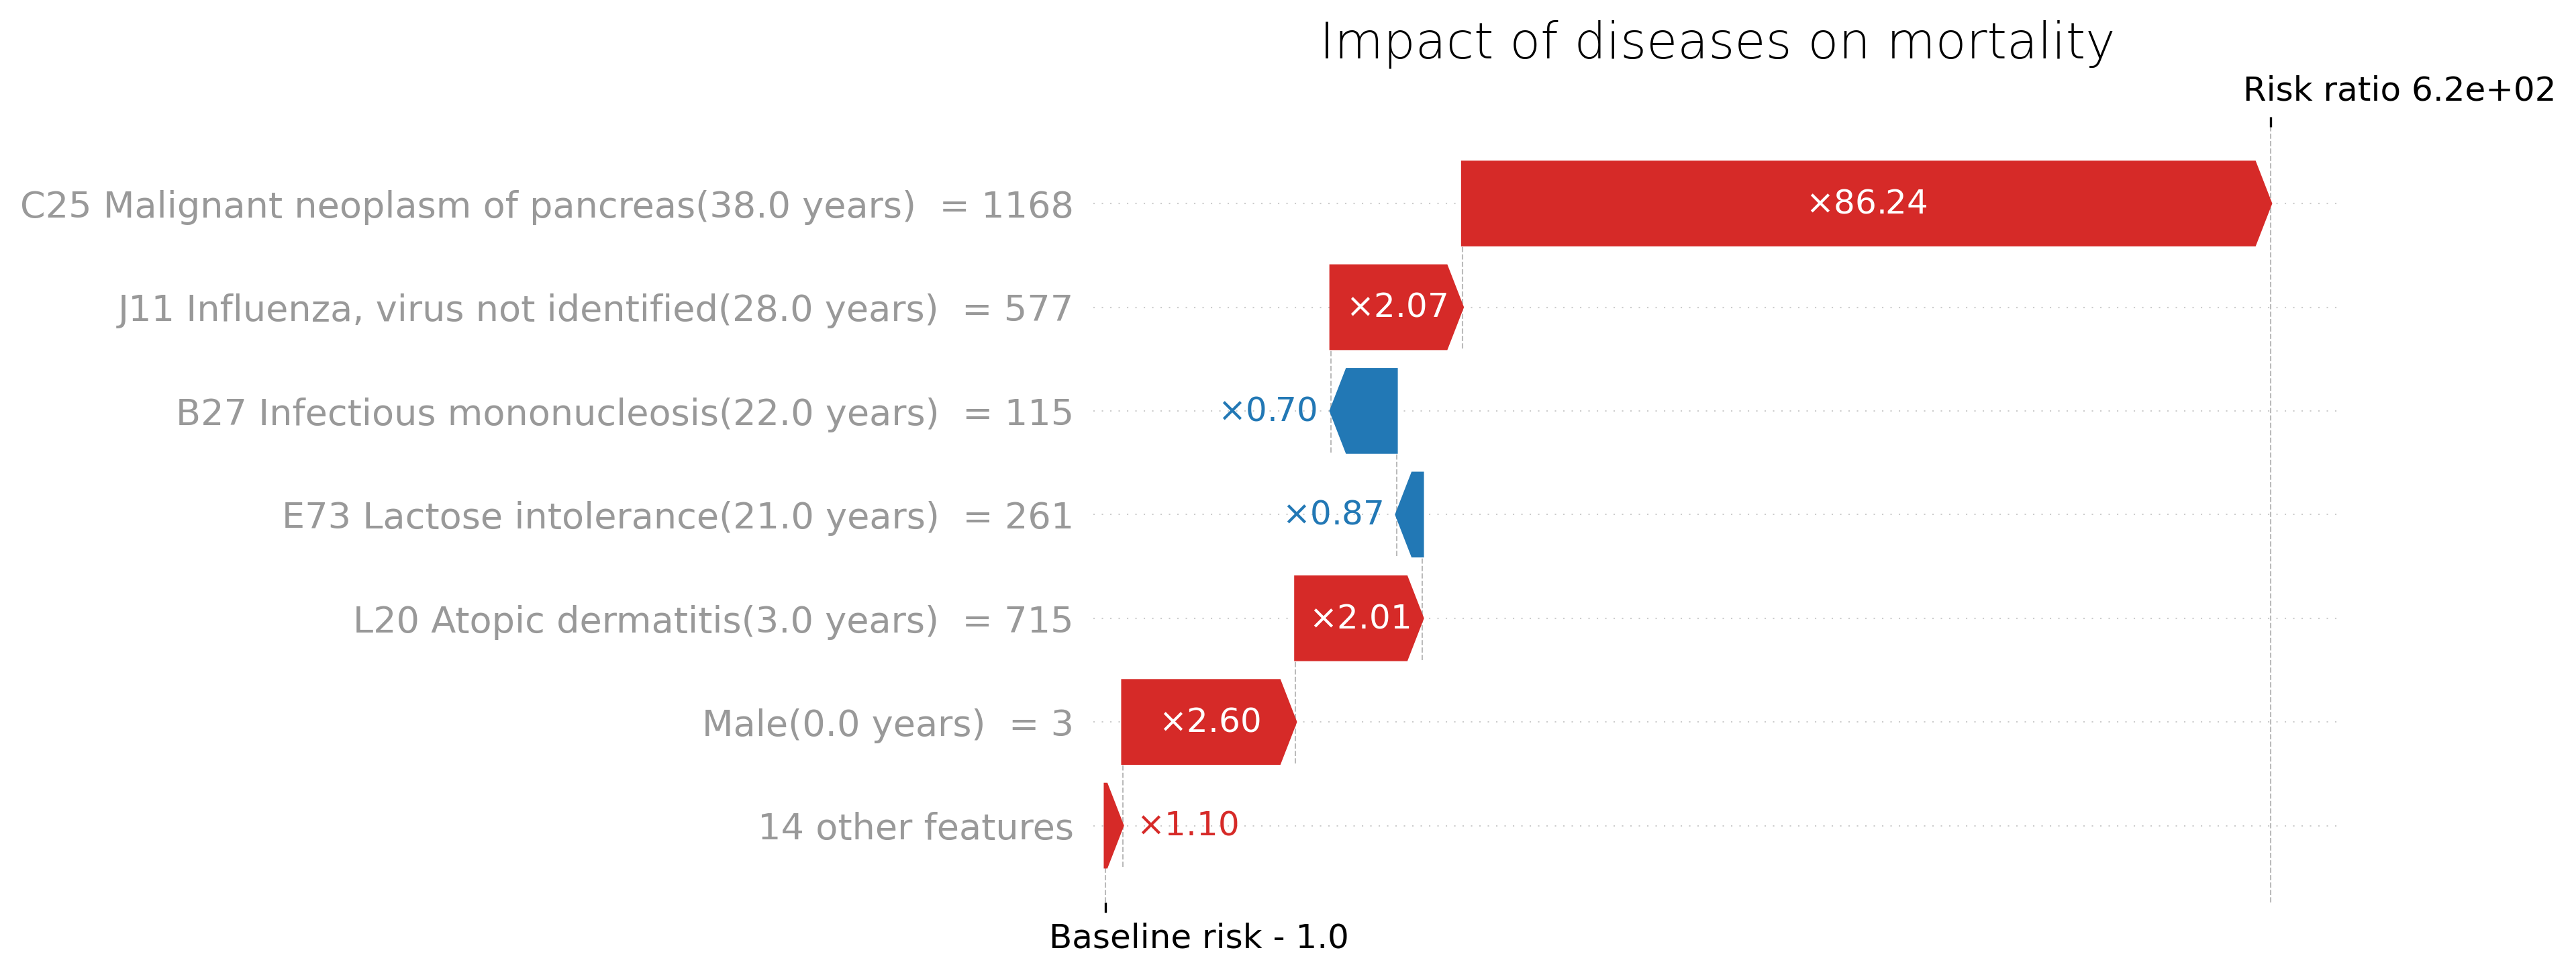

In [10]:
# SHAP values can be interpreted as how much each input token changes predicted logit corresponding to a particular disease. 
# As Delphi logits are log-disease rates, we can convent SHAP values to the disease-specific fold risk changes. 

# Shown below is a waterfall plot, showing SHAP values for the most "influential" diseases within 
# a single trajectory.

from plotting import waterfall

with plt.style.context('default'):
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['font.size'] = 4
    waterfall(shap_values[0, ..., 0], max_display=7, show=False, ages=person_ages)
    plt.gca().set_title('Impact of diseases on mortality', fontweight=1, size=18)
    plt.show()

## Pre-computed many cases

The small synthetic dataset is not enough to properly run following part; if you have access to the full dataset, run `shap-agg-eval.py` to evaluate SHAP values for the entire dataset.

In [11]:
import pickle

with open('shap_agg.pickle', 'rb') as f:
    shap_pkl = pickle.load(f)
    
all_tokens = shap_pkl['tokens']
all_values = shap_pkl['values']

In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df_shap = pd.DataFrame(all_values)
df_shap['token'] = all_tokens.astype('int')

In [13]:
token_count_dict = df_shap['token'].value_counts().sort_index().to_dict()

N_min = 5 # we will only consider diseases that have at least 5 calculated SHAP values, otherwise they are too noisy

columns_more_N = [c for c in df_shap.columns if c == 1269 or (c in token_count_dict and token_count_dict[c] >= N_min)]
df_shap_agg = df_shap[df_shap['token'].apply(lambda x: token_count_dict[x] > N_min)].groupby('token').mean()

Since we now have calculated SHAP values for the entire dataset, we can use them to analyse "connections" between diseases.

For every "predicted"-"predictor" pair, we average all SHAP values for the given pair.

We can further analyse them in sevaral directions:
- For a given disease in the past medical history, which disease rates are most increased by it?
- For a given potential future disease, having which disease in the past medical history would most increase its rate?

Let's see which diseases increase disease risk the most and also which diseases are most influenced by being a heavy smoker.

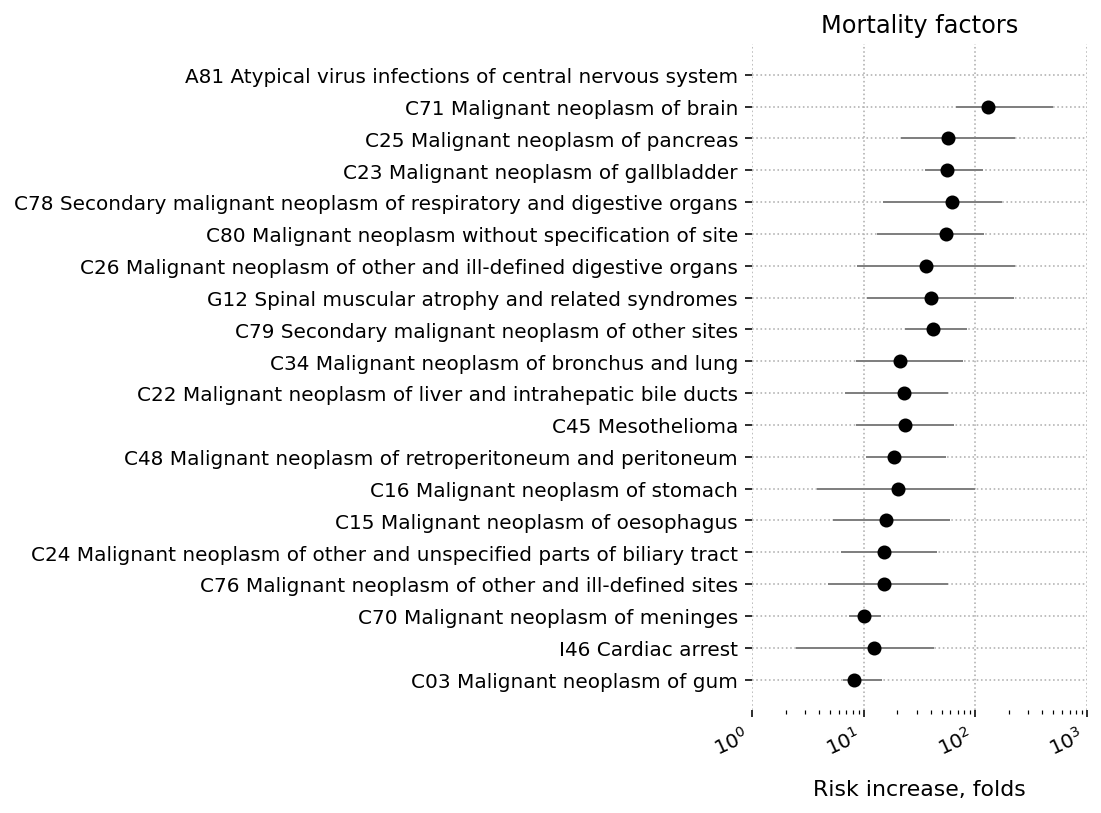

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_shap_distribution(df_melted, y_axis_labels, group_by_col_name, title, x_lim_tuple, highlight_last_dot=True):
    """
    Generates a plot showing median and quartile ranges of SHAP values for different tokens.
    """
    plt.figure(figsize=(3, 6), facecolor='w')
    ax = plt.gca()

    for i, label_for_y_tick in enumerate(y_axis_labels):
        data_for_label = df_melted[df_melted[group_by_col_name] == label_for_y_tick]['value']
        
        if not data_for_label.empty:
            median = np.median(data_for_label)
            quartiles = np.percentile(data_for_label, [25, 75])
            
            dot_color = 'red' if highlight_last_dot and i == len(y_axis_labels) - 1 else 'black'
            ax.plot(median, i, 'o', color=dot_color, zorder=3)
            ax.hlines(i, quartiles[0], quartiles[1], color='gray', linestyles='solid', linewidth=1)

    plt.title(title)
    plt.yticks(range(len(y_axis_labels)), y_axis_labels)
    plt.xticks(rotation=25, ha='right')
    plt.xscale('log')
    plt.xlim(*x_lim_tuple)
    plt.xlabel('Risk increase, folds', size=11, labelpad=10)
    plt.show()

target_token = 1269 
n_first = 20
plot  = True

selected_context_tokens1 = df_shap_agg[target_token].nlargest(n_first).index[::-1]

df_plot_source = df_shap[df_shap['token'].isin(selected_context_tokens1)]
df_plot_melted = df_plot_source[[target_token, 'token']].reset_index(drop=True).melt(id_vars=['token'], value_vars=[target_token])
df_plot_melted['context_token_label'] = df_plot_melted['token'].map(id_to_token)
df_plot_melted['value'] = np.exp(df_plot_melted['value']) 

y_axis_labels1 = [id_to_token[token] for token in selected_context_tokens1]
title1 = 'Mortality factors'
xlim1 = (1, 1000)

plot_shap_distribution(
    df_melted=df_plot_melted,
    y_axis_labels=y_axis_labels1,
    group_by_col_name='context_token_label',
    title=title1,
    x_lim_tuple=xlim1
)

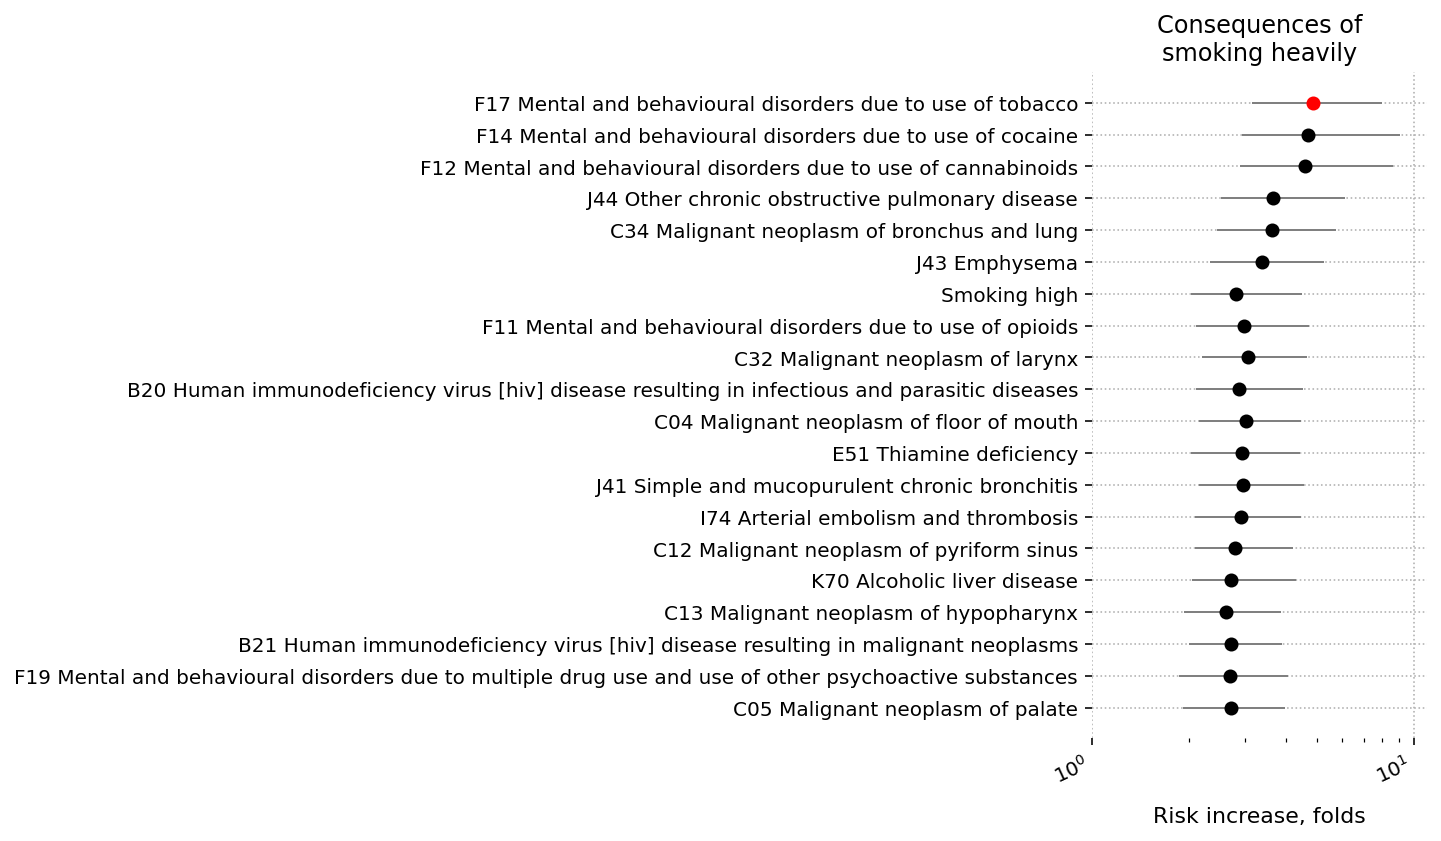

In [15]:
target_token = 9 
n_first = 20

shap_values_for_context = df_shap_agg.loc[target_token]
selected_feature_tokens2 = shap_values_for_context.sort_values(ascending=False).index[:n_first][::-1]

df_plot_source = df_shap[df_shap['token'] == target_token]
df_plot_melted = df_plot_source[[*selected_feature_tokens2, 'token']].reset_index(drop=True).melt(
    id_vars=['token'], 
    value_vars=selected_feature_tokens2, 
    var_name='feature_token_id',
    value_name='raw_shap_value'
)
df_plot_melted['feature_label'] = df_plot_melted['feature_token_id'].map(id_to_token)
df_plot_melted['value'] = np.exp(df_plot_melted['raw_shap_value'])

y_axis_labels = [id_to_token[token] for token in selected_feature_tokens2]
title = 'Consequences of\nsmoking heavily'
xlim = (1, 11)

plot_shap_distribution(
    df_melted=df_plot_melted,
    y_axis_labels=y_axis_labels,
    group_by_col_name='feature_label',
    title=title,
    x_lim_tuple=xlim
)

###  Time-resolved SHAP analysis

Before, we aggregated the calculated SHAP values in a fairly simple way: just averaged them within all "predictor-predicted" pairs. This is an oversimplification, since the context in which these two diseases occur is also important. 

For instance, the amount of time passed since the "predictor" disease occured is important, since some acute conditions may have vastly different effects compared to their chronic forms. 

Now, we will aggregate SHAP values within the pairs, additionally separating them by the time between the "predictor" and "predicted" diseases.

In [16]:
d = get_batch(range(len(np.unique(shap_pkl['people']))), val, val_p2i,  
              select='left', block_size=48, 
              device='cpu', padding='regular')

In [17]:
has_gender = torch.isin(d[0], torch.tensor([2, 3])).any(dim=1).numpy()
is_male = torch.isin(d[0], torch.tensor([3])).any(dim=1).numpy()
is_female = torch.isin(d[0], torch.tensor([2])).any(dim=1).numpy()

In [18]:
def get_person(idx):
    x, y, _, time = get_batch([idx], val, val_p2i,  
              select='left', block_size=64, 
              device=device, padding='random', 
              cut_batch=True)
    
    x, y = x[y > -1], y[y > -1]
    person = []
    for token_id, date in zip(x, y):
        person.append((id_to_token[token_id.item()], date.item()))
    return person, y, time[0][-1]

In [19]:
# the shap result pickle does not contain time, so we need to add it

persons_lengths = []
ages = []
reg_times = []

for p in tqdm(np.unique(shap_pkl['people'])):
    pers = get_person(p)

    reg_time_idx = np.where(np.isin(tokens_to_ids(np.array(pers[0])[:, 0]), np.arange(4, 13)))[0]
    if len(reg_time_idx) > 0:
        reg_time = pers[0][reg_time_idx[0]][1]
    else:
        reg_time = -1

    reg_times += [reg_time] * len(pers[0])
    persons_lengths += [p] * len(pers[0])
    ages += [pers[-1].item()] * len(pers[0])

assert len(ages) == len(df_shap)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99988/99988 [05:13<00:00, 318.81it/s]


In [20]:
all_tokens = shap_pkl['tokens']
all_values = shap_pkl['values']
all_times = shap_pkl['times']

df_shap = pd.DataFrame(all_values)
df_shap['token'] = all_tokens
df_shap['time'] = all_times
df_shap['person'] = shap_pkl['people']
df_shap['age'] = np.array(ages) / 365.25
df_shap['reg_time_years'] = np.array(reg_times) / 365.25

df_shap['Time, years'] = df_shap['time'] / 365.25
df_shap['age_at_token'] = df_shap['age'] - df_shap['time'] / 365.25

df_shap = df_shap[df_shap['reg_time_years'] > 0]

token_count_dict = df_shap['token'].value_counts().sort_index().to_dict()

In [22]:
import numpy as np

def bins_avg(x, y, grid_size=3):
    '''Filter out regions wiht few data points'''
    x, y = np.array(x), np.array(y)
    
    bin_edges = np.arange(np.min(x), np.max(x), grid_size)

    bin_indices = np.digitize(x, bin_edges)
    bin_avgs = np.array([y[bin_indices == i].mean() for i in range(1, len(bin_edges)+1)])

    return bin_edges, bin_avgs


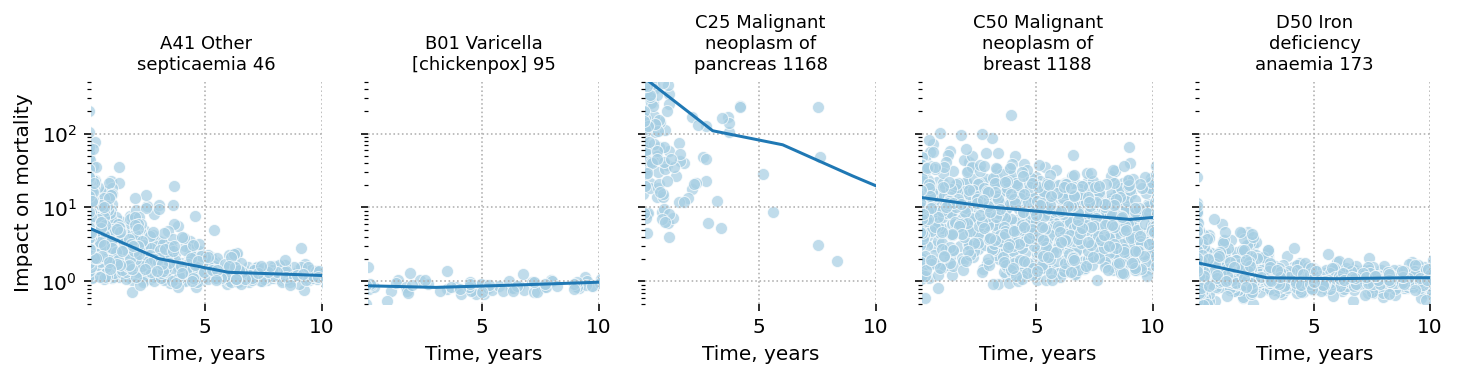

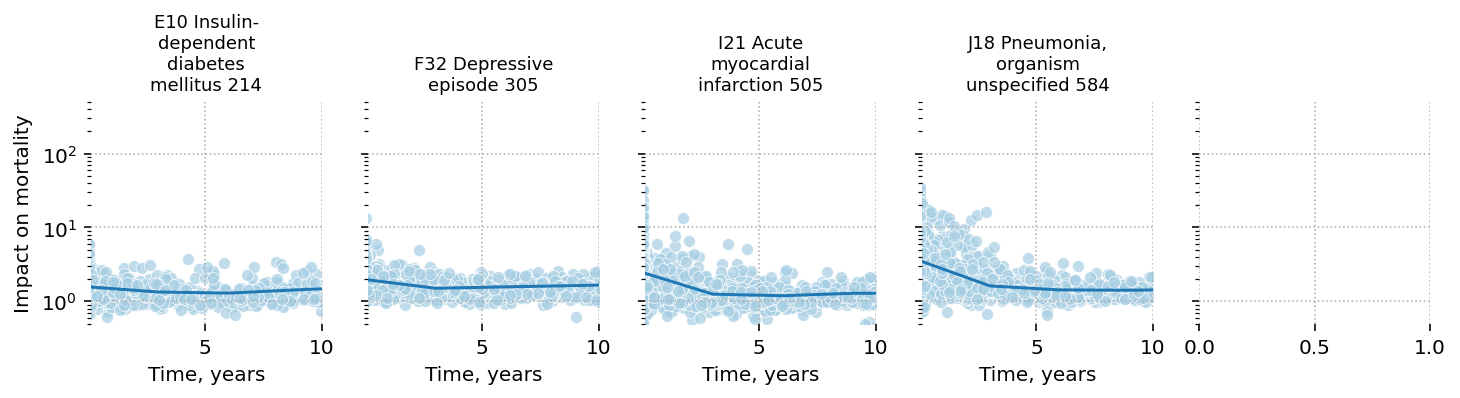

In [23]:
tokens_of_interest = [46, 95, 1168, 1188, 173, 214, 305, 505, 584]
n_groups = len(tokens_of_interest) // 5 + 1

palette_faint = [sns.color_palette("Paired")[0], sns.color_palette("Paired")[2], sns.color_palette("Paired")[4]]
palette_bright = [sns.color_palette("Paired")[1], sns.color_palette("Paired")[3], sns.color_palette("Paired")[5]]

for num_g, token_group in enumerate(np.array_split(tokens_of_interest, n_groups)):

    fig, axs = plt.subplots(1, 5, figsize=(12, 2), sharey=True)
    
    for num, (ax, token_id) in enumerate(zip(axs.flatten(), token_group)):
        df_trait = df_shap[df_shap['token'] == token_id].copy()
        df_trait[1269] = np.exp(df_trait[1269].values)
        df_trait['Time, years'] = df_trait['time'] / 365.25
        df_trait = df_trait.head(2000)
        if len(df_trait) < 2:
            continue

        sns.scatterplot(data=df_trait, x='Time, years', y=1269, ax=ax, color=palette_faint[0], alpha=0.7, rasterized=True)

        x, y = df_trait['Time, years'], df_trait[1269]
        n = 3

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            x, y = bins_avg(x, y, grid_size=n)
        
        ax.plot(x, y, color=palette_bright[0], linewidth=1.5)

        ax.set_ylim(0.5, 500)
        ax.set_xlim(0.1, 10)
        ax.set_ylabel('Impact on mortality');
        ax.set_title(textwrap.fill(id_to_token[token_id], width=15) + f' {token_id}', size=9)
        # ax.set_xscale('log')
    
    ax.set_yscale('log')
    plt.show()


As shown is the graph above, some diseases (pancteatic cancer, miocardial infarction, septiceamia) have a much higher impact on mortality if they occur in the recent past, while others (diabetis, depression) don't have a clear time-dependence.

## Interaction heatmap

To analyse the interactions between diseases more systematically, we can plot a heatmap of the SHAP values for all "predictor-predicted" pairs, sorted by ICD-10 chapter.

Let's plot two separate heatmaps, one for the cases where the "predictor" disease occured in the past 5 years (with the "predicted disease being the reference) and one for the cases where it occured more than 10 years ago.

In [24]:
N_min = 5

token_count_dict_below_5y = df_shap[df_shap['Time, years'] < 5]['token'].value_counts().sort_index().to_dict()
token_count_dict_over_10y = df_shap[df_shap['Time, years'] > 10]['token'].value_counts().sort_index().to_dict()

for d in [token_count_dict_below_5y, token_count_dict_over_10y]:
    for i in range(1300):
        if i not in d:
            d[i] = 0

columns_more_N = [c for c in df_shap.columns if c == 1269 or(c in token_count_dict_below_5y and token_count_dict_below_5y[c] >= N_min and 
                                                             c in token_count_dict_over_10y and token_count_dict_over_10y[c] >= N_min)]
df_shap_agg_below_5y = df_shap[df_shap['token'].apply(lambda x: x in columns_more_N) & (df_shap['Time, years'] < 5)].groupby('token').mean()[columns_more_N]
df_shap_agg_over_10y = df_shap[df_shap['token'].apply(lambda x: x in columns_more_N) & (df_shap['Time, years'] > 10)].groupby('token').mean()[columns_more_N]

In [25]:
from matplotlib.colors import LogNorm

to_exclude_predicted = ['Technical', 'Smoking, Alcohol and BMI', 'Sex', 'XVI. Perinatal Conditions']
to_exclude_predictor = ['Technical', 'Smoking, Alcohol and BMI', 'Sex', 'XVI. Perinatal Conditions', 'Death']

chapter_order = ['I. Infectious Diseases', 'II. Neoplasms',
                   'III. Blood & Immune Disorders', 'IV. Metabolic Diseases', 
                   'V. Mental Disorders', 'VI. Nervous System Diseases',
                   'VII. Eye Diseases', 'VIII. Ear Diseases', 'IX. Circulatory Diseases', 'X. Respiratory Diseases',
                   'XI. Digestive Diseases', 'XII. Skin Diseases',
                   'XIII. Musculoskeletal Diseases', 'XIV. Genitourinary Diseases',
                   'XV. Pregnancy & Childbirth', 'XVI. Perinatal Conditions',
                   'XVII. Congenital Abnormalities', 'Death']

def get_tick_coords(arr):
    return np.where(arr[1:] != arr[:-1])[0]

def plot_full_shap_heatmap(cur_df, title):
    new_death_rows = 10

    for c in range(1269+1, 1269+new_death_rows+1):
        cur_df[c] = cur_df[1269]

    delphi_labels = pd.read_csv("delphi_labels_chapters_colours_icd.csv", index_col=0)
    death_df = delphi_labels[delphi_labels['ICD-10 Chapter (short)']=="Death"].sample(new_death_rows, replace=True)
    death_df['name'] = death_df['name'].apply(lambda x: x + str(np.random.randint(0, 100000)))
    death_df.index = pd.Index(range(1269+1, 1269+new_death_rows+1))
    delphi_labels = pd.concat([delphi_labels, death_df])

    to_exclude_predicted_idx = delphi_labels[~delphi_labels['ICD-10 Chapter (short)'].isin(to_exclude_predicted)].index
    to_exclude_predictor_idx = delphi_labels[~delphi_labels['ICD-10 Chapter (short)'].isin(to_exclude_predictor)].index

    to_exclude_predicted_idx = to_exclude_predicted_idx[to_exclude_predicted_idx.isin(cur_df.columns)]
    to_exclude_predicted_idx = sorted(to_exclude_predicted_idx, key=lambda x: (chapter_order.index(delphi_labels.loc[x, 'ICD-10 Chapter (short)']), x))
    to_exclude_predicted_idx = pd.Index(to_exclude_predicted_idx)

    to_exclude_predictor_idx = to_exclude_predictor_idx[to_exclude_predictor_idx.isin(cur_df.index.values)]
    to_exclude_predictor_idx = sorted(to_exclude_predictor_idx, key=lambda x: (chapter_order.index(delphi_labels.loc[x, 'ICD-10 Chapter (short)']), x))
    to_exclude_predictor_idx = pd.Index(to_exclude_predictor_idx)

    cur_df = cur_df.loc[to_exclude_predictor_idx, to_exclude_predicted_idx]

    row_colors = delphi_labels.iloc[cur_df.index.values]['color'].to_numpy()
    col_colors = delphi_labels.iloc[cur_df.columns]['color'].to_numpy()

    y_tick_coords = get_tick_coords(delphi_labels.iloc[cur_df.index.values]['color'].to_numpy())
    x_tick_coords = get_tick_coords(delphi_labels.iloc[cur_df.columns]['color'].to_numpy())

    g = sns.clustermap(np.exp(cur_df.values), row_cluster=False, col_cluster=False, 
                    row_colors=row_colors, col_colors=col_colors, 
                    # norm=LogNorm(vmin=5e-2, vmax=2e1), 
                    norm=LogNorm(vmin=1e-1, vmax=1e1), 
                    cmap='RdBu_r',
                    figsize=(8.5, 8.5),
                    rasterized=True,
                    )

    g.ax_heatmap.set_xticks(x_tick_coords)
    g.ax_heatmap.set_yticks(y_tick_coords)
    g.ax_heatmap.tick_params(length=0, width=0.5, labelsize=8, grid_alpha=0.6, grid_linewidth=0.35, grid_color='gray')
    g.ax_cbar.tick_params(length=0.5, width=0.6, labelsize=8, grid_alpha=0.45, grid_linewidth=0.45)

    for ch, color in delphi_labels[['ICD-10 Chapter (short)', 'color']].drop_duplicates('color').values:
        col_loc = np.where(col_colors == color)[0].mean() if (col_colors == color).any() else np.nan
        g.ax_heatmap.text(col_loc - 10, -60, ch, va='bottom', rotation=90, ha='left', size=8)

        row_loc = np.where(row_colors == color)[0].mean() if (row_colors == color).any() else np.nan
        g.ax_heatmap.text(-70, row_loc, ch, va='center', ha='right', size=9)

    from matplotlib.patches import Patch
    
    # Create legend for chapter colors
    chapter_color_map = delphi_labels[['ICD-10 Chapter (short)', 'color']].drop_duplicates('color')
    chapter_color_map = chapter_color_map[~chapter_color_map['ICD-10 Chapter (short)'].isin(to_exclude_predicted)]
    handles = [Patch(facecolor=color) for color in chapter_color_map['color']]
    plt.legend(handles, chapter_color_map['ICD-10 Chapter (short)'], title='ICD-10 Chapters',
               bbox_transform=plt.gcf().transFigure, loc='center left', bbox_to_anchor=(.96, 0.5))

    plt.suptitle(title, y=1.1, size=10, x=0.5)
    plt.show()


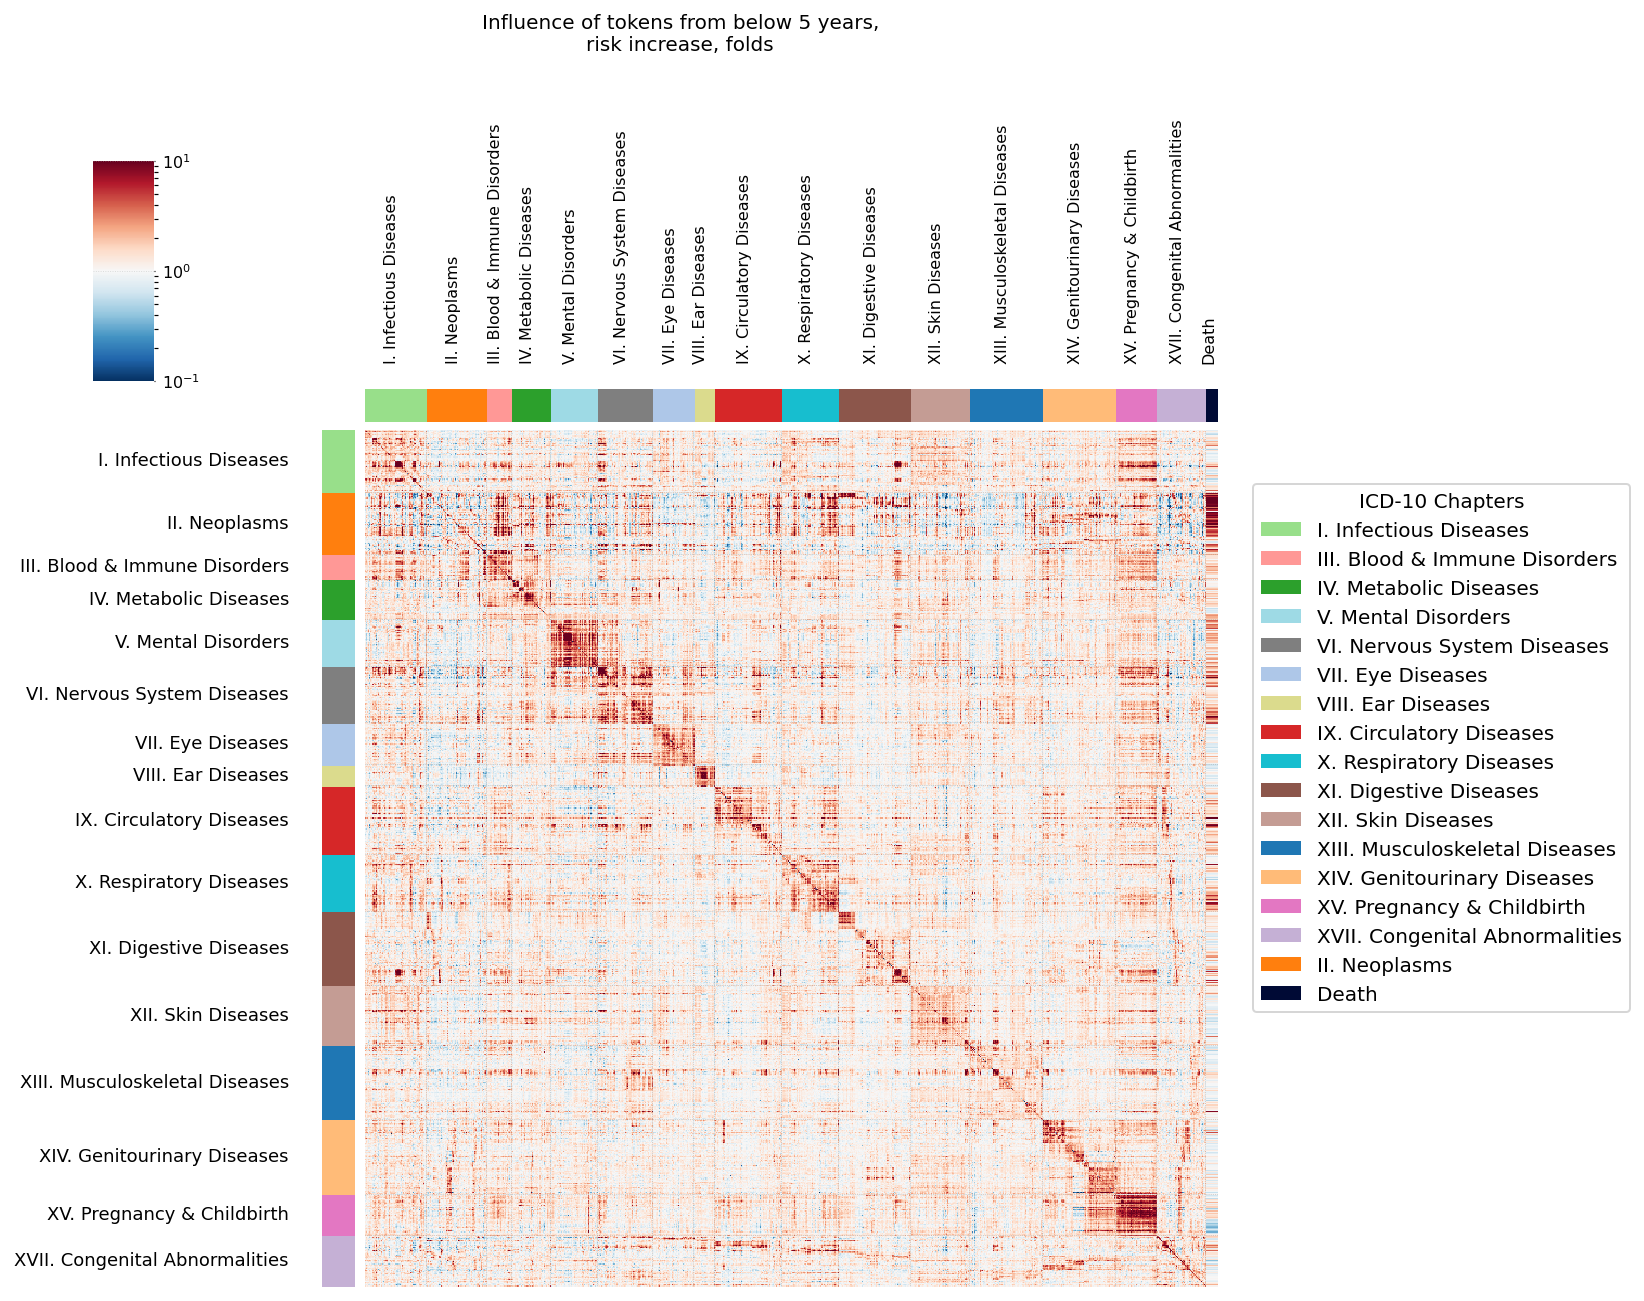

In [26]:
plot_full_shap_heatmap(df_shap_agg_below_5y, 'Influence of tokens from below 5 years,\nrisk increase, folds')

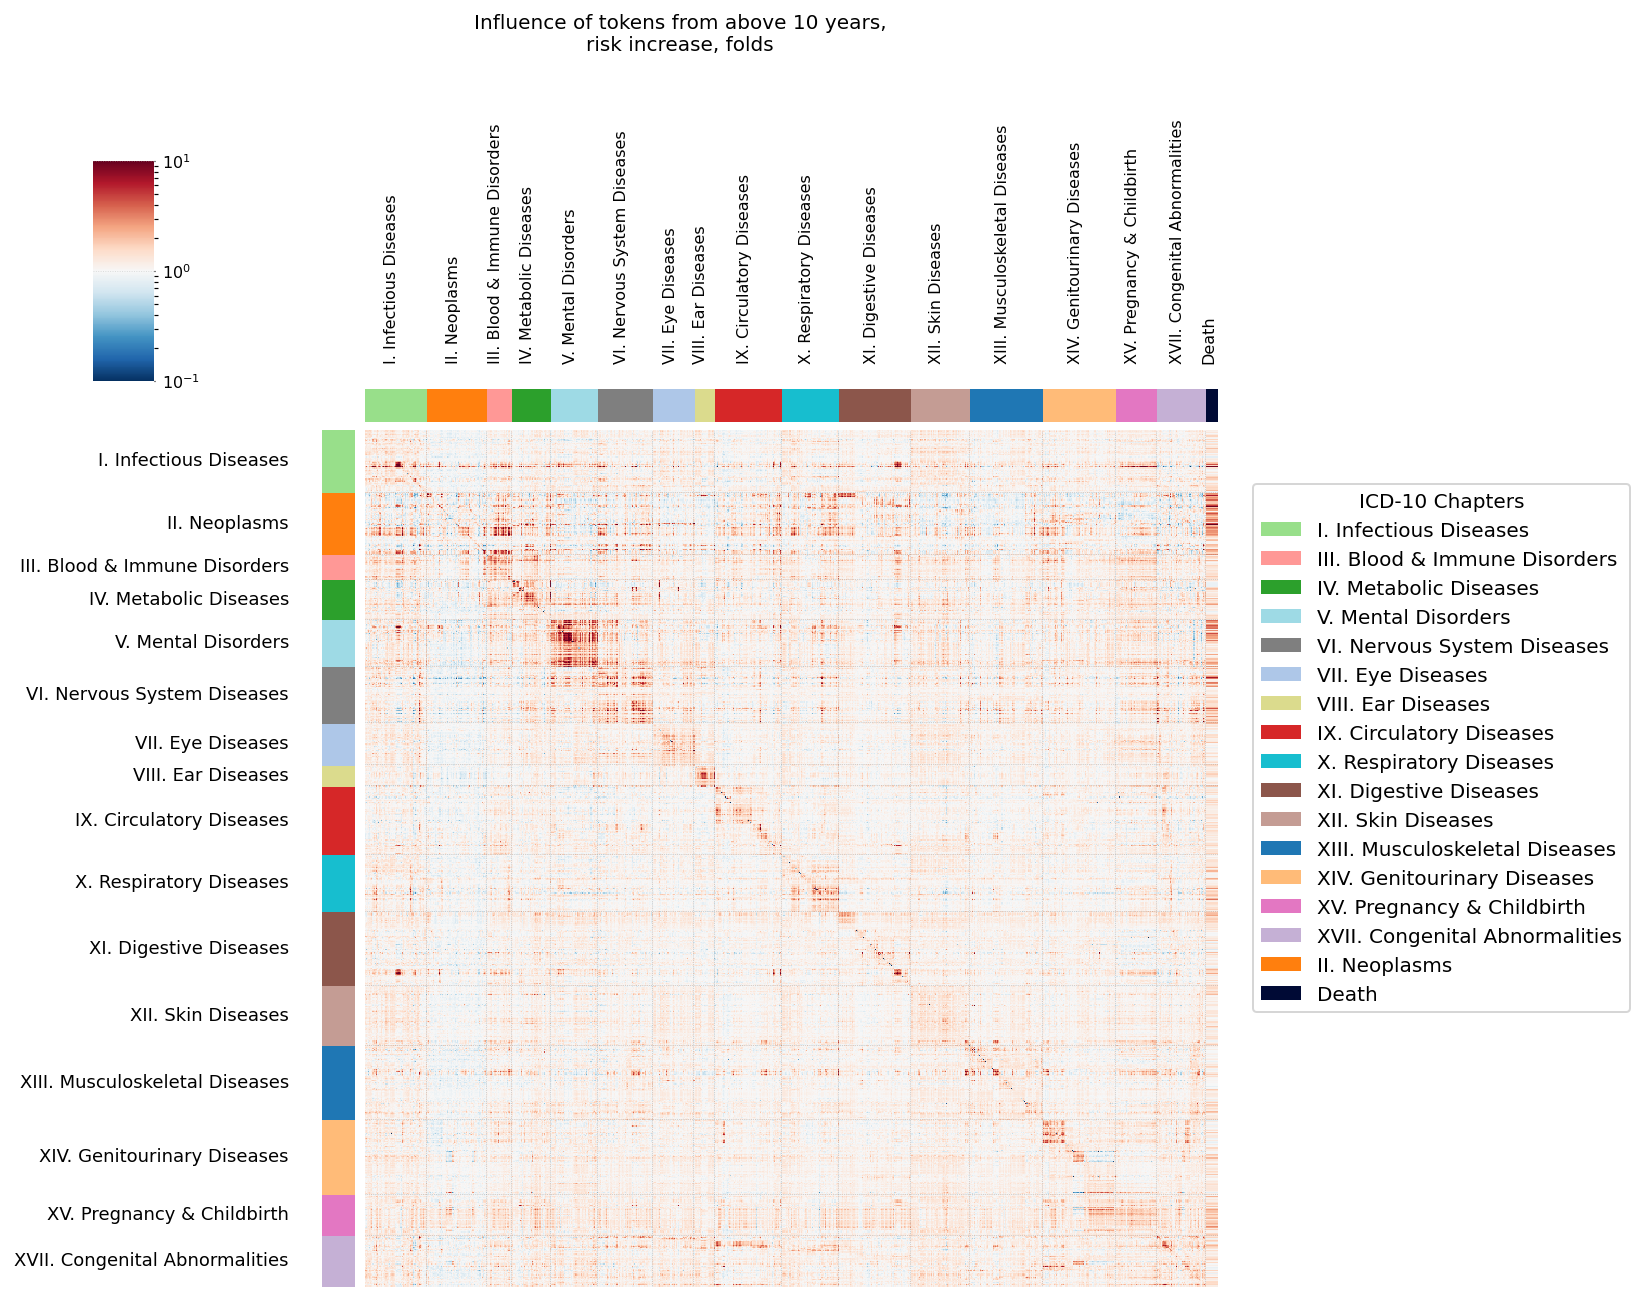

In [27]:
plot_full_shap_heatmap(df_shap_agg_over_10y, 'Influence of tokens from above 10 years,\nrisk increase, folds')

Interestingly, the resulting heatmap has a block diagonal structure, meaning that within a chapter the interactions between diseases tend to be stronger than between chapters. 

The second ("above 10 years") heatmap is also more pale, meaning that most of the disease-disease interactions get weaker over time.  